# Endoscopy Facility Catchment Analysis – Mode-Constrained, Population-Based Modelling

This notebook implements a travel-time-based catchment model for NHS endoscopy facilities. Unlike traditional floating catchment approaches, this method:
- Defines facility catchments by accumulating 50+ population **until the room capacity threshold is reached** (e.g., 100,000 people per room),
- Only includes LSOAs that are **reachable within 60 minutes by car AND 90 minutes by public transport**,
- Supports comparison across sites with varying numbers of endoscopy rooms,
- Enables equity-focused analysis by flagging low-access LSOAs (<3.5 rooms per 100k aged 50+).

Key use cases include:
- Identifying under-served regions,
- Planning expansion locations for endoscopy capacity,
- Testing realistic multi-modal access constraints.

Follow-on options include gravity-weighted decay models and Huff model competition between sites.


In [1]:
# ----------------------------------------------------------
# Step 0 – Imports, File Paths, and Script Path Setup
# ----------------------------------------------------------

import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Optional display settings
import warnings
warnings.filterwarnings("ignore")

# Add custom script directory if needed
script_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/scripts"
if script_dir not in sys.path:
    sys.path.append(script_dir)

# Define base data directory
data_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw"
modality_dir = os.path.join(data_dir, "modality_modelling")

# File paths
gpkg_path = os.path.join(data_dir, "LSOA_5-year_segment_master.gpkg")
travel_csv_path = os.path.join(data_dir, "LSOA_to_LSOA_complete.csv")
modality_counts_path = os.path.join(data_dir, "modality_procedure_counts_by_age_band_2024.csv")
cdc_path = os.path.join(modality_dir, "NHS_SW_Community_Diagnostic_Centres_Capability.csv")
acute_path = os.path.join(modality_dir, "NHS_SW_Acute_Hospitals_Capability.csv")
community_path = os.path.join(modality_dir, "NHS_SW_Community_Hospitals_Capability.csv")  # Newly added

In [2]:
# ----------------------------------------------------------
# Step 1 – Inspect Facility Capability Input Files
# ----------------------------------------------------------

# List of facility files and labels
facility_files = {
    "CDC": cdc_path,
    "Acute": acute_path,
    "Community": community_path
}

# Loop through and inspect each
for label, path in facility_files.items():
    print(f"\n--- {label} Facility File ---")
    try:
        df = pd.read_csv(path)
        print(f"Loaded: {os.path.basename(path)}")
        print("Columns:", df.columns.tolist())
        display(df.head(3))
    except Exception as e:
        print(f"Failed to load {label} file: {e}")



--- CDC Facility File ---
Loaded: NHS_SW_Community_Diagnostic_Centres_Capability.csv
Columns: ['Code', 'Name', 'CT Scanners', 'MRI Scanners', 'Endoscopy Rooms', 'Address 1', 'Address 2', 'Address 3', 'Address 4', 'Address 5', 'Postcode', 'Type', 'Parent Organisation Code', 'Parent Organisation Name', 'postcode', 'latitude', 'longitude', 'lsoa21cd', 'msoa21cd', 'oa21cd', 'icb_code', 'local_authority']


,Code,Name,CT Scanners,MRI Scanners,Endoscopy Rooms,Address 1,Address 2,Address 3,Address 4,Address 5,...,Parent Organisation Code,Parent Organisation Name,postcode,latitude,longitude,lsoa21cd,msoa21cd,oa21cd,icb_code,local_authority
0,B4B4S,Bsw Banes Locality CDC,1,1,3,Foxcote Avenue,Bath Business Park,Peasedown St. John,Bath,NaN,...,QOX,"NHS Bath and North East Somerset, Swindon and ...",BA28SQ,-2.416516,51.311327,E01014444,E02003006,E00072943,E54000040,E06000022
1,K1W4U,Salisbury CDC,1,1,0,Avon Approach,NaN,NaN,Salisbury,NaN,...,QOX,"NHS Bath and North East Somerset, Swindon and ...",SP13SL,-1.797518,51.071737,E01032014,E02006671,E00163295,E54000040,E06000054
2,O0D8X,West Swindon CDC,1,1,0,West Swindon District Centre,NaN,NaN,Swindon,NaN,...,QOX,"NHS Bath and North East Somerset, Swindon and ...",SN57DL,-1.829554,51.558467,E01015569,E02003233,E00078739,E54000040,E06000030



--- Acute Facility File ---
Loaded: NHS_SW_Acute_Hospitals_Capability.csv
Columns: ['Code', 'Trust Name', 'Name', 'CT Scanners', 'MRI Scanners', 'Endoscopy Rooms', 'Address 1', 'Address 2', 'Address 3', 'Address 4', 'Address 5', 'Postcode', 'Type', 'Parent Organisation Code', 'Parent Organisation Name', 'postcode', 'latitude', 'longitude', 'lsoa21cd', 'msoa21cd', 'oa21cd', 'icb_code', 'local_authority']


,Code,Trust Name,Name,CT Scanners,MRI Scanners,Endoscopy Rooms,Address 1,Address 2,Address 3,Address 4,...,Parent Organisation Code,Parent Organisation Name,postcode,latitude,longitude,lsoa21cd,msoa21cd,oa21cd,icb_code,local_authority
0,RTE01,Gloucestershire Hospitals NHS Foundation Trust,Cheltenham General Hospital,2,2,2,Sandford Road,NaN,NaN,Cheltenham,...,QR1,NHS Gloucestershire Integrated Care Board,GL537AN,-2.071883,51.892120,E01022116,E02004608,E00168922,E54000043,E07000078
1,RTE03,Gloucestershire Hospitals NHS Foundation Trust,Gloucestershire Royal Hospital,4,2,2,Great Western Road,NaN,NaN,Gloucester,...,QR1,NHS Gloucestershire Integrated Care Board,GL13NN,-2.232073,51.866379,E01022312,E02004637,E00168979,E54000043,E07000081
2,RH5A8,Somerset NHS Foundation Trust,Musgrove Park Hospital,3,2,3,Musgrove Park,NaN,NaN,Taunton,...,QSL,NHS Somerset Integrated Care Board,TA15DA,-3.121693,51.011574,E01029302,E02006109,E00149288,E54000038,E06000066



--- Community Facility File ---
Loaded: NHS_SW_Community_Hospitals_Capability.csv
Columns: ['Code', 'Name', 'Endoscopy Rooms', 'Address 1', 'Address 2', 'Address 3', 'Address 4', 'Address 5', 'Postcode', 'Type', 'Parent Organisation Code', 'Parent Organisation Name', 'postcode', 'latitude', 'longitude', 'lsoa21cd', 'msoa21cd', 'oa21cd', 'icb_code', 'local_authority']


,Code,Name,Endoscopy Rooms,Address 1,Address 2,Address 3,Address 4,Address 5,Postcode,Type,Parent Organisation Code,Parent Organisation Name,postcode,latitude,longitude,lsoa21cd,msoa21cd,oa21cd,icb_code,local_authority
0,RN330,Devizes Community Hospital,0,New Park Road,NaN,NaN,Devizes,Wiltshire,SN10 1EF,Community hospital,QOX,"NHS Bath and North East Somerset, Swindon and ...",SN101EF,-1.993230,51.354581,E01031854,E02006638,E00162466,E54000040,E06000054
1,RN332,Melksham Community Hospital,0,Spa Road,NaN,NaN,Melksham,Wiltshire,SN12 7NZ,Community hospital,QOX,"NHS Bath and North East Somerset, Swindon and ...",SN127NZ,-2.131543,51.367131,E01032069,E02006680,E00163564,E54000040,E06000054
2,RN334,Trowbridge Community Hospital,0,Adcroft Street,NaN,NaN,Trowbridge,Wiltshire,BA14 8PH,Community hospital,QOX,"NHS Bath and North East Somerset, Swindon and ...",BA148PH,-2.209882,51.325295,E01034533,E02006684,E00184207,E54000040,E06000054


In [3]:
# ----------------------------------------------------------
# Step 2 – Filter Facilities with ≥1 Endoscopy Room & Convert to GeoDataFrames
# ----------------------------------------------------------

from shapely.geometry import Point

# Load each facility dataset
cdc_df = pd.read_csv(cdc_path)
acute_df = pd.read_csv(acute_path)
community_df = pd.read_csv(community_path)

# Define facility inputs
facility_inputs = {
    "CDC": cdc_df,
    "Acute": acute_df,
    "Community": community_df
}

facility_gdfs = {}

for label, df in facility_inputs.items():
    # Copy and filter
    filtered = df.copy()
    filtered = filtered[filtered["Endoscopy Rooms"] >= 1].copy()
    
    # Create geometry from (lon, lat)
    filtered["geometry"] = filtered.apply(
        lambda row: Point(row["longitude"], row["latitude"]),
        axis=1
    )
    
    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(filtered, geometry="geometry", crs="EPSG:4326")
    
    # Store with source label
    gdf["source"] = label
    facility_gdfs[label] = gdf
    
    print(f"{label}: {len(gdf)} facilities with ≥1 Endoscopy Room")

# Unpack for later use
cdc_gdf = facility_gdfs["CDC"]
acute_gdf = facility_gdfs["Acute"]
community_gdf = facility_gdfs["Community"]


CDC: 7 facilities with ≥1 Endoscopy Room
Acute: 18 facilities with ≥1 Endoscopy Room
Community: 7 facilities with ≥1 Endoscopy Room


In [4]:
# ----------------------------------------------------------
# Step 3 – Combine All Facilities with ≥1 Endoscopy Room via LSOA Join (Centroids)
# ----------------------------------------------------------

# Load LSOA geometries
lsoa_geom = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]

# Define consistent columns (excluding geometry – will be added from LSOA)
common_cols = [
    "Code", "Name", "Endoscopy Rooms", "postcode", "latitude", "longitude",
    "lsoa21cd", "msoa21cd", "oa21cd", "icb_code", "local_authority", "source"
]

# Combine all DataFrames
combined_df = pd.concat(
    [cdc_gdf[common_cols], acute_gdf[common_cols], community_gdf[common_cols]],
    ignore_index=True
)

# Drop any missing LSOA codes (can't map these)
combined_df = combined_df.dropna(subset=["lsoa21cd"]).copy()
combined_df["lsoa21cd"] = combined_df["lsoa21cd"].astype(str)

# Merge with LSOA geometries and use centroids for plotting
facilities_gdf = combined_df.merge(lsoa_geom, on="lsoa21cd", how="left")
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=lsoa_geom.crs)
facilities_gdf["geometry"] = facilities_gdf["geometry"].centroid

# Confirm and preview
print(f"Combined facility GeoDataFrame created with {len(facilities_gdf)} rows (with geometry from LSOA centroids)")
display(facilities_gdf.tail(10))


Combined facility GeoDataFrame created with 32 rows (with geometry from LSOA centroids)


,Code,Name,Endoscopy Rooms,postcode,latitude,longitude,lsoa21cd,msoa21cd,oa21cd,icb_code,local_authority,source,geometry
22,REF12,Royal Cornwall Hospital (Treliske),4,TR13LJ,-5.091464,50.266686,E01018865,E02003909,E00182858,E54000036,E06000052,Acute,POINT (165472.69 41377.957)
23,RWV12,North Devon District Hospital,2,EX314JB,-4.050431,51.092169,E01020134,E02004181,E00101949,E54000037,E07000043,Acute,POINT (256448.783 134246.292)
24,RH8D2,Derriford Hospital,5,PL68DH,-4.113684,50.416720,E01015092,E02003126,E00181102,E54000037,E06000026,Acute,POINT (249966.001 59397.871)
25,RA773,South Bristol Community Hospital,2,BS140DE,-2.584902,51.413400,E01014607,E02003058,E00073784,E54000039,E06000023,Community,POINT (359576.993 168643.963)
26,RH853,Tiverton and District Hospital,3,EX166NT,-3.492967,50.909404,E01020048,E02004168,E00101491,E54000037,E07000042,Community,POINT (295409.662 113212.901)
27,RDYFE,Victoria Hospital W'Borne,1,BH211ER,-1.995918,50.802195,E01020428,E02004252,E00103521,E54000041,E06000059,Community,POINT (400826.455 99863.661)
28,RTQ21,Cirencester Hospital,1,GL71UY,-1.975637,51.712104,E01022194,E02004621,E00112793,E54000043,E07000079,Community,POINT (402274.817 201973.001)
29,U4O3U,Forest of Dean Community Hospital,1,GL143HY,-2.508314,51.832836,E01022240,E02004629,E00113046,E54000043,E07000080,Community,POINT (365271.103 215428.294)
30,RTQ04,Stroud General Hospital,1,GL52HY,-2.208136,51.743022,E01022410,E02004656,E00113918,E54000043,E07000082,Community,POINT (386372.313 204607.011)
31,RH5K6,Bridgwater Community Hospital,3,TA64GU,-2.974124,51.140563,E01035115,E02006070,E00186613,E54000038,E06000066,Community,POINT (332239.983 137640.457)


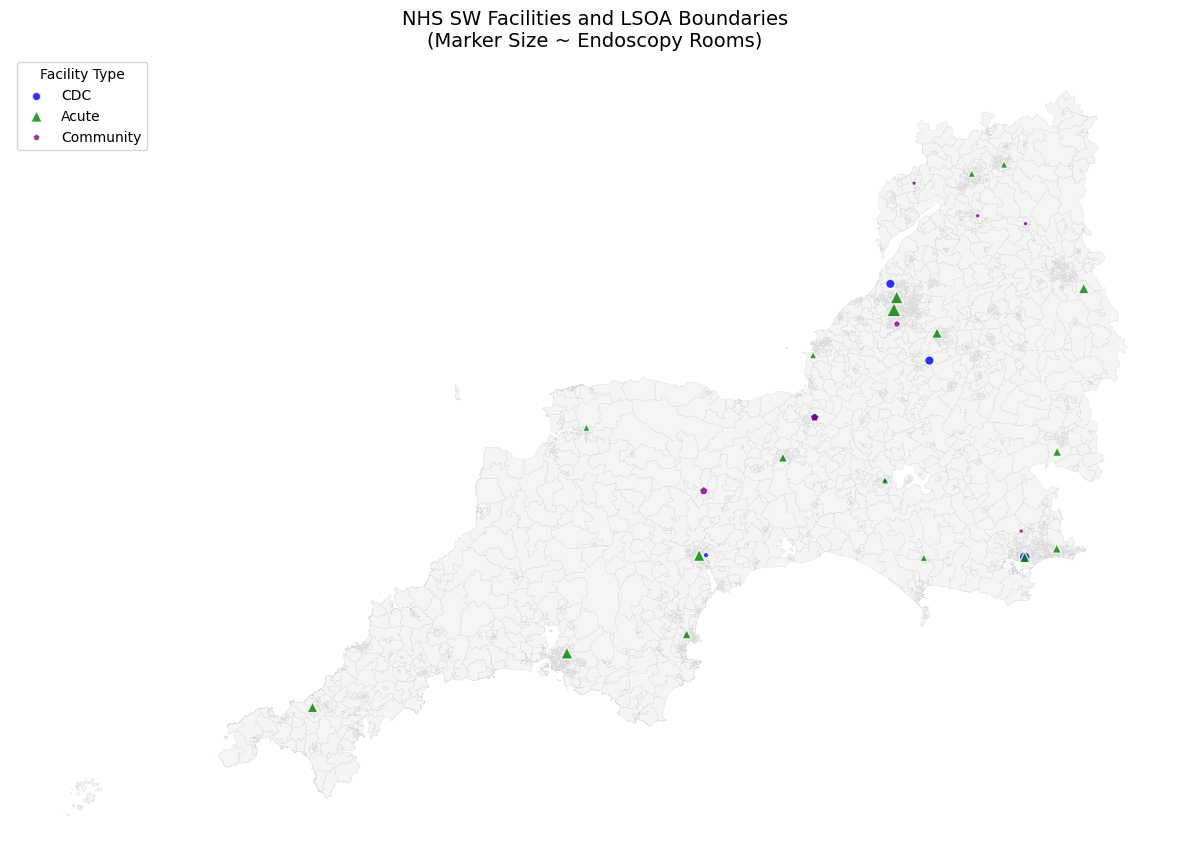

In [5]:
# ----------------------------------------------------------
# Step 4 – Visualise NHS SW Facilities and LSOA Boundaries
# (Marker Size ~ Endoscopy Rooms)
# ----------------------------------------------------------

import matplotlib.pyplot as plt

# Load LSOA polygons
lsoa_gdf = gpd.read_file(gpkg_path)[["lsoa21cd", "geometry"]]

# Ensure CRS matches facilities
lsoa_gdf = lsoa_gdf.to_crs(facilities_gdf.crs)

# Set consistent figure size
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot LSOA boundaries as background
lsoa_gdf.plot(ax=ax, color="whitesmoke", edgecolor="lightgrey", linewidth=0.2)

# Plot facilities by type with different markers and sizes
for label, colour, marker in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "p")]:
    subset = facilities_gdf[facilities_gdf["source"] == label]
    subset.plot(
        ax=ax,
        color=colour,
        markersize=subset["Endoscopy Rooms"] * 15,
        marker=marker,
        label=label,
        alpha=0.8,
        edgecolor="white"
    )

# Final plot tweaks
ax.set_title("NHS SW Facilities and LSOA Boundaries\n(Marker Size ~ Endoscopy Rooms)", fontsize=14)
ax.axis("off")
ax.legend(title="Facility Type", loc="upper left")

plt.tight_layout()
plt.show()


In [19]:
# ------------------------------------------------------------------
# STEP 5 – Filter Travel Matrix for Reachable Facility Sites (Car ≤ 90 mins)
# ------------------------------------------------------------------

# 5.1 – Reload full travel matrix
travel_df = pd.read_csv(travel_csv_path)

# 5.2 – Ensure destination LSOAs are known valid diagnostic facilities
valid_lsoas = facilities_gdf["lsoa21cd"].astype(str).unique()
travel_df["destination_name"] = travel_df["destination_name"].astype(str)

# Filter rows where destination is a known valid facility LSOA
travel_df = travel_df[travel_df["destination_name"].isin(valid_lsoas)].copy()

# 5.3 – Filter to travel times ≤ 60 minutes by car (exclude PT for now)
travel_df_filtered = travel_df[travel_df["travel_time_car"] <= 90].copy()

# 5.4 – Confirm filtering success
print("Filtered travel matrix shape:", travel_df_filtered.shape)
print("Max car travel time (should be ≤ 90):", travel_df_filtered["travel_time_car"].max())



Filtered travel matrix shape: (34029, 5)
Max car travel time (should be ≤ 90): 89.997260046


In [20]:
# ----------------------------------------------------------
# Step 6.1 – Load LSOA GeoPackage with Age Data
# and Compute Population Aged 50–74
# ----------------------------------------------------------

# Load the LSOA layer from the GeoPackage
lsoa_gdf = gpd.read_file(gpkg_path, layer="LSOA_5-year_segment_master")

# Confirm columns loaded
print("Loaded columns:", lsoa_gdf.columns.tolist())

# Define expected age columns for population aged 50–74
age_cols_50_74 = ['age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74']

# Check if the columns exist
missing_cols = [col for col in age_cols_50_74 if col not in lsoa_gdf.columns]
if missing_cols:
    raise ValueError(f"Missing expected age columns in LSOA data: {missing_cols}")

# Calculate total population aged 50–74
lsoa_gdf["pop_50_74"] = lsoa_gdf[age_cols_50_74].sum(axis=1)

# Extract relevant columns for merging later
lsoa_pop = lsoa_gdf[["lsoa21cd", "pop_50_74"]].copy()

# Rename for compatibility with travel matrix
lsoa_pop = lsoa_pop.rename(columns={"lsoa21cd": "origin_name"})


Loaded columns: ['ICB23NM', 'ladnm', 'ladcd', 'msoa21nm', 'msoa21cd', 'lsoa21nmw', 'lsoa21cd', 'total_population', 'age_0_4', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 'age_75_79', 'age_80_84', 'age_85_plus', 'lat', 'long', 'bng_e', 'bng_n', 'lsoa21nm', 'geometry']


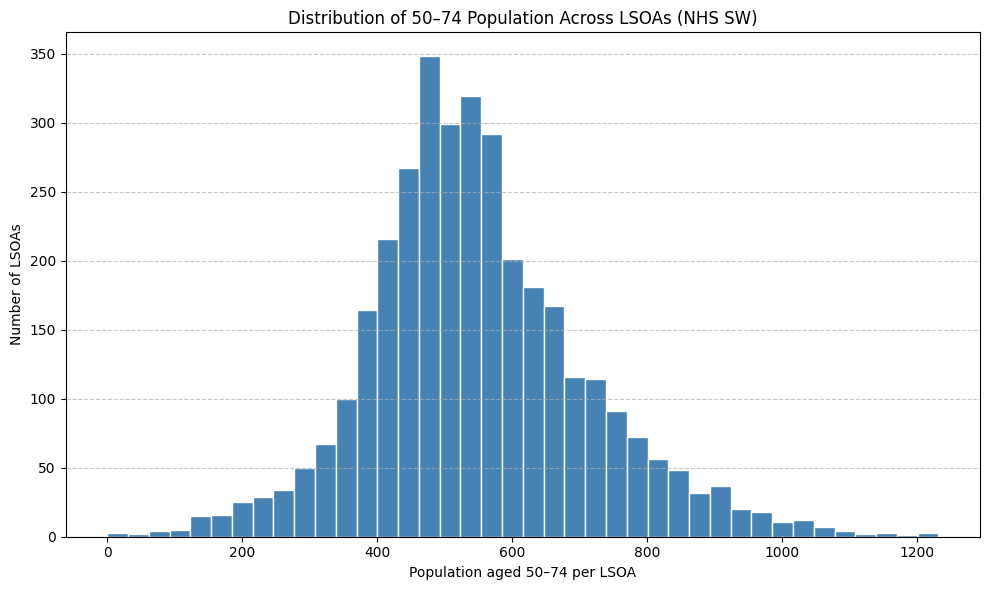

In [16]:
# ----------------------------------------------------------
# Step 7 – Histogram of LSOA Populations (Age 50–74)
# ----------------------------------------------------------

import matplotlib.pyplot as plt

# 7.1 – Filter non-null population entries
pop_values = lsoa_gdf["pop_50_74"].dropna()

# 7.2 – Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pop_values, bins=40, color="steelblue", edgecolor="white")
plt.xlabel("Population aged 50–74 per LSOA")
plt.ylabel("Number of LSOAs")
plt.title("Distribution of 50–74 Population Across LSOAs (NHS SW)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


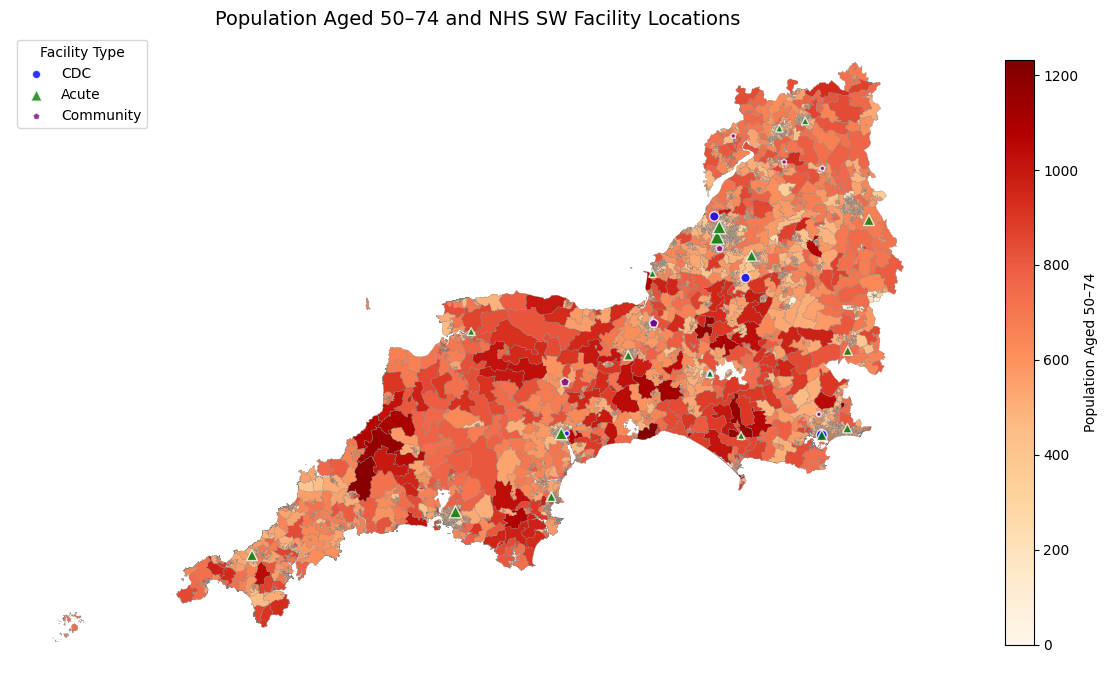

In [17]:
import matplotlib.pyplot as plt

# Step 8 – Choropleth of 50–74 Population with Facility Markers and Smaller Colourbar

# 8.1 – Prepare LSOA GeoDataFrame with relevant columns and CRS match
choropleth_gdf = lsoa_gdf[["lsoa21cd", "geometry", "pop_50_74"]].copy()
choropleth_gdf = choropleth_gdf.to_crs(facilities_gdf.crs)

# 8.2 – Initialise plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 8.3 – Plot choropleth with reduced-size colourbar
choropleth = choropleth_gdf.plot(
    column="pop_50_74",
    cmap="OrRd",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    legend_kwds={"label": "Population Aged 50–74", "shrink": 0.5},
    ax=ax
)

# 8.4 – Overlay facility markers
for label, colour, marker in [("CDC", "blue", "o"), ("Acute", "green", "^"), ("Community", "purple", "p")]:
    subset = facilities_gdf[facilities_gdf["source"] == label]
    subset.plot(
        ax=ax,
        color=colour,
        markersize=subset["Endoscopy Rooms"] * 15,
        marker=marker,
        label=label,
        alpha=0.8,
        edgecolor="white"
    )

# 8.5 – Final formatting
ax.set_title("Population Aged 50–74 and NHS SW Facility Locations", fontsize=14)
ax.axis("off")
ax.legend(title="Facility Type", loc="upper left", frameon=True)

plt.tight_layout()
plt.show()


In [21]:
# ----------------------------------------------------------
# Export Key DataFrames to Processed Endoscopy Folder
# ----------------------------------------------------------

import os

# Define export folder
export_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy"
os.makedirs(export_dir, exist_ok=True)

# File paths
facilities_export = os.path.join(export_dir, "facilities_with_geometry.gpkg")
travel_export = os.path.join(export_dir, "travel_times_filtered.csv")
lsoa_export = os.path.join(export_dir, "lsoa_population_50_74.geojson")
travel_cumulative_export = os.path.join(export_dir, "travel_times_cumulative_50_74.csv")

# ----------------------------------------------------------
# Ensure travel_full_sorted exists (recreate if necessary)
# ----------------------------------------------------------
if "travel_full_sorted" not in locals():
    # Merge population into filtered travel matrix
    travel_with_pop = travel_df_filtered.merge(
        lsoa_gdf[["lsoa21cd", "pop_50_74"]],
        left_on="origin_name",
        right_on="lsoa21cd",
        how="left"
    )

    # Merge with facility metadata
    travel_full = travel_with_pop.merge(
        facilities_gdf[["Code", "Name", "source"]],
        left_on="destination_name",
        right_on="Code",
        how="left"
    )

    # Sort and compute cumulative population
    travel_full_sorted = travel_full.sort_values(by=["destination_name", "travel_time_car"]).copy()
    travel_full_sorted["cum_pop_50_74"] = travel_full_sorted.groupby("destination_name")["pop_50_74"].cumsum()

# ----------------------------------------------------------
# Perform Exports
# ----------------------------------------------------------

# Export facility locations with geometry
facilities_gdf.to_file(facilities_export, driver="GPKG")

# Export filtered travel times (pre-cumulative)
travel_df_filtered.to_csv(travel_export, index=False)

# Export LSOA with population 50–74
lsoa_gdf.to_file(lsoa_export, driver="GeoJSON")

# Export cumulative travel time per facility
travel_full_sorted.to_csv(travel_cumulative_export, index=False)

print("All key files exported to:", export_dir)


All key files exported to: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy
